In [46]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.api import keras
from tensorflow.keras.utils import timeseries_dataset_from_array

from hpcscripts.sharedutils.trainingutils import LoadModel, SetLowTFVerbose, MakeSinglePrediction
from hpcscripts.sharedutils.nomalization import DF_Nomalize, denorm
from hpcscripts.sharedutils.modelutils import SelectModelPrompt
from hpcscripts.option import pathhandler as ph
from hpcscripts.option import globalparams as G_PARAMS

SetLowTFVerbose()

### Import Data

In [59]:
def get_file_list():
    train_dir = ph.GetProcessedPath("Selected")
    test_dir  = ph.GetProcessedPath("Test")

    train_list = os.listdir(train_dir)
    test_list  = os.listdir(test_dir)

    for i, test_file in enumerate (test_list):
        train_list.remove(test_file)
        test_list[i] = os.path.join(test_dir, test_file)

    for i, train_file in enumerate (train_list):
        train_list[i] = os.path.join(train_dir, train_file)

    print ("Files found: ")
    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    # Slicing
    print ("\nAfter Slicing: ")
    # train_list = train_list[:3]
    # test_list  = test_list[:3]

    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    return train_list, test_list

In [48]:
train_list, test_list = get_file_list()

Files found: 
	Train count: 350
	Test count : 61

After Slicing: 
	Train count: 350
	Test count : 3


### With Simple Function

In [49]:
# Function Version

from typing import List

def to_datasets(files: List[str]):

    np_data = []

    for i, file in enumerate(files):
        try:
            data = pd.read_csv(file)
            data = data.loc[:, 
                            ["hralt_m", "theta_rad", "aoac_rad", "cas_mps", "elv_l_rad"]
                    ]
        except:
            raise Exception("Can't process {}".format(file))

        ds = timeseries_dataset_from_array(
                    data.to_numpy(),
                    targets=None,
                    sequence_length=5,
                    sequence_stride=1,
                    batch_size=99999
                )
        
        for elem in ds.take(1):
            np_data.append(
                    elem.numpy()
                )
            print ("{}, i: {}".format(elem.numpy().shape, i), end='\r')
    
    print()
    concated_np = np.concatenate(np_data)
    return concated_np
    # return tf.data.Dataset.from_tensor_slices(concated_np)


In [50]:
train_ds = to_datasets(train_list)

# for elem in train_ds:
#     print (elem)

shuffle_size = train_ds.shape[0]
print (shuffle_size)

train_ds = tf.data.Dataset.from_tensor_slices(train_ds).shuffle(shuffle_size).batch(32, drop_remainder=True)
train_ds.element_spec

(397, 5, 5), i: 349
108904


TensorSpec(shape=(32, 5, 5), dtype=tf.float64, name=None)

In [51]:
count = 0
for elem in train_ds:
    count += 1
    print ("{}, Count: {}".format(elem.shape, count), end='\r')

print ()
print (str(count).ljust(100, " "))
print ("Total: {:.0f}".format(count*32))

(32, 5, 5), Count: 3403
3403                                                                                                
Total: 108896


### With WindowGenerator Class version

In [60]:
## Get File List
train_list, test_list = get_file_list()

## Get Combined Train Files to calculate norm param
COMBINEDDATA_DIR = "Ready"
def ImportTrainingData():
    train_file = os.path.join(ph.GetProcessedPath(COMBINEDDATA_DIR), "Train_set.csv")
    test_file  = os.path.join(ph.GetProcessedPath(COMBINEDDATA_DIR), "Test_set.csv")
    eval_file  = os.path.join(ph.GetProcessedPath(COMBINEDDATA_DIR), "Eval_set.csv")

    train_data = pd.read_csv(train_file)
    test_data  = pd.read_csv(test_file)
    eval_data  = pd.read_csv(eval_file)

    return train_data, test_data, eval_data

train_data, test_data, eval_data = ImportTrainingData()
train_data, norm_param = DF_Nomalize(train_data)

Files found: 
	Train count: 350
	Test count : 61

After Slicing: 
	Train count: 350
	Test count : 61


In [143]:
# Definition for WindowGenerator are written based on tensorflow official
# tutorial on:
#        https://www.tensorflow.org/tutorials/structured_data/time_series
# which licensed under Apache License, Version 2.0



# Copyright 2019 The TensorFlow Authors

#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import List

class WindowGenerator():

    USABLE_COLUMNS  = set (G_PARAMS.FEATURE_COLUMNS + G_PARAMS.SEQUENTIAL_LABELS)
    FEATURE_COLUMNS = G_PARAMS.FEATURE_COLUMNS

    def __init__(self, input_width:int, label_width:int=1, shift:int=1,
                train_list=None, test_list=None, val_list=None,
                label_columns=None,
                norm_param:dict=None,
                shuffle_train:bool=True,
                print_check:bool=True):
        # Store list of the data.
        self.train_list = train_list
        self.test_list = test_list
        self.val_list = val_list

        # Set params
        self.shuffle_train = shuffle_train
        self.norm_param = norm_param

        # Work out the label column indices.
        self.input_columns = self.FEATURE_COLUMNS
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}

        self.column_indices = self.__get_column_indices()

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        # Check if there's missing parameters
        if print_check:
            self.check_params()

    def __get_column_indices(self):
        # Get 1 Sample DataFrame and use it to determine column indices
        df = pd.read_csv(self.train_list[0])
        return {name: i for i, name in enumerate(df.columns) if name in self.USABLE_COLUMNS}

    def check_params(self):
        print ("train_list \t {}".format("Found" if self.train_list != None else "Missing"))
        print ("test_list \t {}".format("Found" if self.test_list != None else "Missing"))
        print ("val_list \t {}".format("Found" if self.val_list != None else "Missing"))
        print ("label_columns \t {}".format("Found" if self.label_columns != None else "Missing"))
        print ("norm_param \t {}".format("Found" if self.norm_param != None else "Missing"))

        print ("""\nMissing norm_columns will cause data not to be normalized when creating datasets.""")


    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.input_columns is not None:
            inputs = tf.stack(
                            [inputs[:, :, self.column_indices[name]] for name in self.input_columns],
                            axis=-1
                    )
        if self.label_columns is not None:
            labels = tf.stack(
                            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                            axis=-1
                    )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def make_dataset(self, file_list: List[str], do_shuffle:bool = False, batch_size:int=32):
        np_data = []
        for file in file_list:
            try:
                data = pd.read_csv(file)
                #
                # PREPROCESS HERE, 
                if not self.norm_param == None:
                    data = DF_Nomalize(data, self.norm_param)
                # NORMALIZATION, ETC.
            except:
                raise Exception("Can't process {}".format(file))

            ds = timeseries_dataset_from_array(
                        data=data.to_numpy(),
                        targets=None,
                        sequence_length=self.total_window_size,
                        sequence_stride=1,
                        batch_size=99999
                    )
            
            for elem in ds.take(1):
                np_data.append(
                        elem.numpy()
                    )
        
        concated_np = np.concatenate(np_data)
        buffer_size = concated_np.shape[0]

        if do_shuffle:
            ds = tf.data.Dataset.from_tensor_slices(concated_np).shuffle(buffer_size)
        else:
            ds = tf.data.Dataset.from_tensor_slices(concated_np)

        _batch_size = buffer_size
        if not batch_size == None:
            _batch_size = batch_size
            
        ds = ds.batch(_batch_size, drop_remainder=True)
        ds = ds.map(self.split_window)

        return ds

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    @property
    def train(self):
        return self.make_dataset(self.train_list, self.shuffle_train)

    @property
    def val(self):
        return self.make_dataset(self.val_list)

    @property
    def test(self):
        return self.make_dataset(self.test_list)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [94]:
w1 = WindowGenerator(
                    input_width=1, shift=0,
                    train_list=train_list,
                    val_list=test_list,
                    norm_param=norm_param,
                    label_columns=["elv_l_rad", "theta_rad"],
                    shuffle_train=False,
                    print_check=False
                )
w1

Total window size: 1
Input indices: [0]
Label indices: [0]
Label column name(s): ['elv_l_rad', 'theta_rad']

In [95]:
w1.check_params()

train_list 	 Found
test_list 	 Missing
val_list 	 Found
label_columns 	 Found
norm_param 	 Found

Missing norm_columns will cause data not to be normalized when creating datasets.


In [64]:
# train_ds = w1.train

Check wether it's the datasets and manual process have the same results or not

In [57]:
# Datasets
for example_inputs, example_labels in train_ds.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

    print (example_inputs[0, :, :])
    print (example_labels[0, :, :])

# Manual
_df = pd.read_csv(train_list[0])
_df = DF_Nomalize(_df, norm_param)
_df = _df.loc[:, w1.USABLE_COLUMNS]

print ("\nFrom Manual Processing:")
_df.head()

Inputs shape (batch, time, features): (32, 1, 4)
Labels shape (batch, time, features): (32, 1, 2)
tf.Tensor([[0.94019011 1.35636893 1.18616038 1.2749389 ]], shape=(1, 4), dtype=float64)
tf.Tensor([[0.08291782 1.35636893]], shape=(1, 2), dtype=float64)

From Manual Processing:


,hralt_m,aoac_rad,cas_mps,elv_l_rad,theta_rad
0,0.940190,1.186160,1.274939,0.082918,1.356369
1,0.943212,1.079478,1.269368,0.057060,1.277792
2,0.941701,1.094718,1.255442,0.108777,1.211305
3,0.911481,1.003276,1.263798,0.160494,1.199216
4,0.912992,1.262362,1.269368,0.186353,1.205261


### Train Test

In [210]:
window = WindowGenerator(
                    input_width=10, shift=0,
                    train_list=train_list,
                    val_list=test_list,
                    norm_param=norm_param,
                    label_columns=["elv_l_rad"],
                    shuffle_train=True,
                    print_check=False
                )

train_ds = window.train
val_ds   = window.val

In [211]:
# Datasets
for example_inputs, example_labels in train_ds.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

    print (example_inputs[0, :, :])
    print (example_labels[0, :, :])

Inputs shape (batch, time, features): (32, 10, 4)
Labels shape (batch, time, features): (32, 1, 1)
tf.Tensor(
[[ 0.45968395  1.00579867  1.03375683  1.27772421]
 [ 0.44608472  0.99370969  0.91183665  1.25265635]
 [ 0.43701857  0.97557727  0.91183665  1.22201786]
 [ 0.43248549  0.87282408  0.62226992  1.2136619 ]
 [ 0.41586421  0.68545012  0.34794619  1.18023809]
 [ 0.40226498  0.46181028  0.13458387  1.21087659]
 [ 0.3856437   0.25025941 -0.21594163  1.15238491]
 [ 0.37204447  0.05079752 -0.47502765  1.0576841 ]
 [ 0.37204447 -0.15470886 -0.56646978  1.07439601]
 [ 0.36297831 -0.45088049 -0.93223563  1.03818688]], shape=(10, 4), dtype=float64)
tf.Tensor([[-1.27897142]], shape=(1, 1), dtype=float64)


In [218]:
MAX_EPOCHS = 20

def compile_and_fit(model, train_ds, val_ds, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(train_ds, epochs=MAX_EPOCHS,
                        validation_data=val_ds,
                        callbacks=[early_stopping])
    return history

linear = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(10,),
                           activation='relu'),
    tf.keras.layers.Dense(units=1)
])


history = compile_and_fit(linear, train_ds, val_ds)

Epoch 1/20
3348/3348 [==============================] - 10s 2ms/step - loss: 0.7945 - mean_absolute_error: 0.5819 - val_loss: 0.5302 - val_mean_absolute_error: 0.4613
Epoch 2/20
3348/3348 [==============================] - 8s 2ms/step - loss: 0.7829 - mean_absolute_error: 0.5741 - val_loss: 0.5001 - val_mean_absolute_error: 0.4452
Epoch 3/20
3348/3348 [==============================] - 7s 2ms/step - loss: 0.7773 - mean_absolute_error: 0.5722 - val_loss: 0.5350 - val_mean_absolute_error: 0.4649
Epoch 4/20
3348/3348 [==============================] - 7s 2ms/step - loss: 0.7744 - mean_absolute_error: 0.5710 - val_loss: 0.5383 - val_mean_absolute_error: 0.4600


In [219]:
filename = test_list[15]
ds = window.make_dataset([filename], batch_size=None)
# for feature, labels in ds.take(1):
#     print (feature)
#     print (labels)
features, labels = next(iter(ds))

result = linear.predict(features)
print (features.shape)
print (result.shape)

pd.read_csv(filename).shape

(414, 10, 4)
(414, 1, 1)


(423, 59)

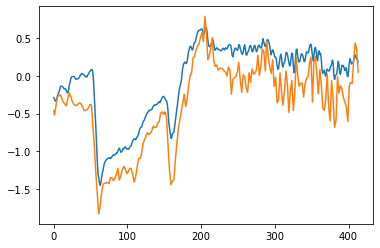

In [220]:
import matplotlib.pyplot as plt

x_num = result.shape[0]
index = [a for a in range(x_num)]

plt.plot(index, result.reshape(x_num,))
plt.plot(index, labels.numpy().reshape(x_num,))

plt.show()